In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
df = pd.read_csv("../preprocessed/14a_maln_potential_preprocessed_ohe.csv")

df.head()

,low_PA,hosp_pastyr,sig_hlth_decln,func_diffhigh,low_edu,age_cat,mmorb_q3,memory_prob,mobility_lim,imp_vision,...,diff_eating,FSDAD,vomit_past30,PROTDEN,maln_potential,RIAGENDR,RXDCOUNT,MHpro_pastyr,MH_Depressed,MH_lossofinterest
0,1.0,0.0,0.0,0.0,1.0,1,1,0.0,1.0,0.0,...,0.0,1.0,0.0,4.246933,0.0,1,2.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,2,1,0.0,1.0,0.0,...,0.0,1.0,0.0,0.869919,0.0,1,5.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,2,0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.000000,1.0,2,4.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1,0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.217219,0.0,1,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,3,1,0.0,1.0,0.0,...,0.0,1.0,0.0,2.183202,0.0,1,3.0,0.0,1.0,0.0


In [113]:
df.shape

(2767, 32)

In [94]:
# check duplicate rows

df.duplicated().sum()

0

In [95]:
df.isnull().sum().sum()

0

In [114]:
df = df[predictors + ['maln_potential']]

In [115]:
df['maln_potential'].value_counts() # imbalanced

0.0    2129
1.0     638
Name: maln_potential, dtype: int64

In [116]:
# oversampling technique 

from imblearn.over_sampling import SMOTE

X_ov, y_ov = df.drop(columns='maln_potential'), df['maln_potential']

sm = SMOTE(random_state=42)
X_ov, y_ov = sm.fit_resample(X_ov, y_ov)

In [117]:
y_ov.value_counts()

0.0    2129
1.0    2129
Name: maln_potential, dtype: int64

In [118]:
# undersampling technique 

from imblearn.under_sampling import RandomUnderSampler

X_und, y_und = df.drop(columns='maln_potential'), df['maln_potential']


rus = RandomUnderSampler(random_state=42)
X_und, y_und = rus.fit_resample(X_und, y_und)

y_und.value_counts()

0.0    638
1.0    638
Name: maln_potential, dtype: int64

### 1. ML modeling

In [107]:
from sklearn import svm, metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning

In [15]:
def estimate_acc(classifiers, X, y, stratified_k_fold=False,
                conv_to_series=False):
    X_loc, y_loc = X, y

    if stratified_k_fold:
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    else:
        cv = KFold(n_splits=10, shuffle=True, random_state=7)
    results = pd.DataFrame(columns=['clf', 'acc', 'std', 'class0_acc', 'class1_acc'])
    
    for i, clf in enumerate(classifiers):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning) # ignore warns from Logreg
            scores = cross_val_score(clf, X_loc, y_loc, scoring='accuracy', cv=cv)
    #         results.loc[i] = (clf, np.mean(scores), np.std(scores))
            if conv_to_series:
                y_pred = pd.Series(cross_val_predict(clf, X_loc, y_loc, cv=cv))
            else:
                y_pred = cross_val_predict(clf, X_loc, y_loc, cv=cv)
            results.loc[i] = (clf, accuracy_score(y_loc, y_pred), np.std(scores),
                              accuracy_score(y_loc[y_loc == 0.0], y_pred[y_loc == 0.0]),
                              accuracy_score(y_loc[y_loc == 1.0], y_pred[y_loc == 1.0]),
                              )
        
    return results

In [16]:
def estimate_acc_norm(classifiers, X, y, stratified_k_fold=False,
                conv_to_series=False):
    X_loc, y_loc = X, y

    if stratified_k_fold:
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    else:
        cv = KFold(n_splits=10, shuffle=True, random_state=7)
    results = pd.DataFrame(columns=['clf', 'acc', 'std', 'class0_acc', 'class1_acc'])
    
    for i, clf in enumerate(classifiers):
        scalar = StandardScaler()
        pipeline = Pipeline([('transformer', scalar),
                             ('estimator', clf)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning) # ignore warns from Logreg
            scores = cross_val_score(pipeline, X_loc, y_loc, scoring='accuracy', cv=cv)
            if conv_to_series:
                y_pred = pd.Series(cross_val_predict(clf, X_loc, y_loc, cv=cv))
            else:
                y_pred = cross_val_predict(clf, X_loc, y_loc, cv=cv)
            results.loc[i] = (clf, accuracy_score(y_loc, y_pred), np.std(scores),
                              accuracy_score(y_loc[y_loc == 0.0], y_pred[y_loc == 0.0]),
                              accuracy_score(y_loc[y_loc == 1.0], y_pred[y_loc == 1.0]),
                              )
        
    return results

In [17]:
# Undersampled (balanced dataset)
classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(), 
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

estimate_acc(classifiers, X_und, y_und, stratified_k_fold=True)

,clf,acc,std,class0_acc,class1_acc
0,LogisticRegression(max_iter=2000),0.602665,0.046694,0.609718,0.595611
1,SVC(),0.541536,0.038821,0.554859,0.528213
2,RandomForestClassifier(),0.572884,0.030588,0.595611,0.550157
3,GaussianNB(),0.583856,0.035913,0.722571,0.445141
4,DecisionTreeClassifier(),0.539185,0.033447,0.536050,0.542320
5,LinearDiscriminantAnalysis(),0.601097,0.046438,0.614420,0.587774
6,KNeighborsClassifier(),0.521160,0.037504,0.570533,0.471787


In [18]:
# Oversampling (balanced dataset)
classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

estimate_acc(classifiers, X_ov, y_ov, stratified_k_fold=True)

,clf,acc,std,class0_acc,class1_acc
0,LogisticRegression(max_iter=2000),0.647957,0.025699,0.633161,0.662752
1,SVC(),0.567872,0.015808,0.608736,0.527008
2,RandomForestClassifier(),0.860498,0.015809,0.969939,0.751057
3,GaussianNB(),0.631282,0.020755,0.520432,0.742132
4,DecisionTreeClassifier(),0.779944,0.018977,0.765618,0.794270
5,LinearDiscriminantAnalysis(),0.647487,0.027200,0.630813,0.664162
6,KNeighborsClassifier(),0.723579,0.021487,0.510099,0.937060


In [12]:
# OLD:Undersampled (balanced dataset)
classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(), 
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

estimate_acc(classifiers, X_und, y_und, stratified_k_fold=True)

,clf,acc,std,class0_acc,class1_acc
0,LogisticRegression(max_iter=2000),0.626106,0.055603,0.634956,0.617257
1,SVC(),0.543142,0.045949,0.502212,0.584071
2,RandomForestClassifier(),0.565265,0.059987,0.564159,0.566372
3,GaussianNB(),0.577434,0.062465,0.741150,0.413717
4,DecisionTreeClassifier(),0.533186,0.030098,0.511062,0.555310
5,LinearDiscriminantAnalysis(),0.626106,0.048287,0.632743,0.619469
6,KNeighborsClassifier(),0.540929,0.034844,0.588496,0.493363


In [13]:
# OLD:Oversampling (balanced dataset)
classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

estimate_acc(classifiers, X_ov, y_ov, stratified_k_fold=True)

,clf,acc,std,class0_acc,class1_acc
0,LogisticRegression(max_iter=2000),0.656513,0.025741,0.637955,0.675070
1,SVC(),0.563725,0.026849,0.423669,0.703782
2,RandomForestClassifier(),0.851891,0.021051,0.960784,0.742997
3,GaussianNB(),0.630252,0.045380,0.537815,0.722689
4,DecisionTreeClassifier(),0.761204,0.027706,0.753501,0.768908
5,LinearDiscriminantAnalysis(),0.654412,0.024421,0.630252,0.678571
6,KNeighborsClassifier(),0.717787,0.020696,0.518207,0.917367


In [14]:
# OLD: Stratified (imbalanced)

X, y = df.drop(columns='maln_potential'), df['maln_potential']

classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

estimate_acc(classifiers, X, y, stratified_k_fold=True)

,clf,acc,std,class0_acc,class1_acc
0,LogisticRegression(max_iter=2000),0.752128,0.015453,0.969188,0.066372
1,SVC(),0.759574,0.002128,1.000000,0.000000
2,RandomForestClassifier(),0.758511,0.015007,0.985294,0.042035
3,GaussianNB(),0.693085,0.022321,0.814426,0.309735
4,DecisionTreeClassifier(),0.633511,0.032807,0.744398,0.283186
5,LinearDiscriminantAnalysis(),0.751064,0.015195,0.964286,0.077434
6,KNeighborsClassifier(),0.723936,0.016728,0.921569,0.099558


In [15]:
# Not stratified (imbalanced)

classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

estimate_acc(classifiers, X, y)

,clf,acc,std,class0_acc,class1_acc
0,LogisticRegression(max_iter=2000),0.755851,0.018495,0.973389,0.068584
1,SVC(),0.759574,0.018395,1.000000,0.000000
2,RandomForestClassifier(),0.755319,0.018889,0.982493,0.037611
3,GaussianNB(),0.688830,0.030672,0.808824,0.309735
4,DecisionTreeClassifier(),0.648404,0.024468,0.753501,0.316372
5,LinearDiscriminantAnalysis(),0.752128,0.017513,0.968487,0.068584
6,KNeighborsClassifier(),0.715957,0.020213,0.919468,0.073009


In [36]:
def estimate_acc(classifiers, X, y, stratified_k_fold=False, conv_to_series=False,
                random_state=7):
    X_loc, y_loc = X, y

    if stratified_k_fold:
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
    else:
        cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    
    results = pd.DataFrame(columns=['clf', 'acc', 'std', 'class0_acc', 'class1_acc'])
    feature_importances = pd.DataFrame(index=X.columns)
    
    for i, clf in enumerate(classifiers):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning) # ignore warns from Logreg
            scores = cross_val_score(clf, X_loc, y_loc, scoring='accuracy', cv=cv)
            if conv_to_series:
                y_pred = pd.Series(cross_val_predict(clf, X_loc, y_loc, cv=cv))
            else:
                y_pred = cross_val_predict(clf, X_loc, y_loc, cv=cv)
            results.loc[i] = (clf, accuracy_score(y_loc, y_pred), np.std(scores),
                              accuracy_score(y_loc[y_loc == 0.0], y_pred[y_loc == 0.0]),
                              accuracy_score(y_loc[y_loc == 1.0], y_pred[y_loc == 1.0]))
        
        # Fit the classifier to the entire dataset to get feature importances
        clf.fit(X_loc, y_loc)
        if hasattr(clf, 'coef_'):
            importance = np.abs(clf.coef_[0])
            feature_importances[clf.__class__.__name__] = importance
        elif hasattr(clf, 'feature_importances_'):
            importance = clf.feature_importances_
            feature_importances[clf.__class__.__name__] = importance
    
    return results, feature_importances

classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

res, imps = estimate_acc(classifiers, X_ov, y_ov)

In [31]:
imps

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,LinearDiscriminantAnalysis
low_PA,0.332721,0.058412,0.075480,0.336101
hosp_pastyr,0.641946,0.039330,0.026983,0.637975
sig_hlth_decln,0.413494,0.010065,0.012743,0.403808
func_diffhigh,0.105541,0.018232,0.010393,0.109451
low_edu,0.283759,0.060556,0.166702,0.290484
age_cat,0.152616,0.039176,0.025961,0.153824
mmorb_q3,1.407830,0.024348,0.017041,1.400989
memory_prob,0.052894,0.012072,0.005574,0.056704
mobility_lim,0.162991,0.008660,0.005977,0.174492
imp_vision,0.115436,0.011082,0.008879,0.116180


In [38]:
imps

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,LinearDiscriminantAnalysis
low_PA,0.332721,0.057003,0.074345,0.336101
hosp_pastyr,0.641946,0.043089,0.030701,0.637975
sig_hlth_decln,0.413494,0.009784,0.014152,0.403808
func_diffhigh,0.105541,0.019501,0.011641,0.109451
low_edu,0.283759,0.063318,0.166702,0.290484
age_cat,0.152616,0.039804,0.024881,0.153824
mmorb_q3,1.407830,0.023865,0.014122,1.400989
memory_prob,0.052894,0.012966,0.005292,0.056704
mobility_lim,0.162991,0.009809,0.008951,0.174492
imp_vision,0.115436,0.010767,0.010257,0.116180


In [37]:
classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

res, imps = estimate_acc(classifiers, X_ov, y_ov, random_state=505)

imps

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,LinearDiscriminantAnalysis
low_PA,0.332721,0.057003,0.074345,0.336101
hosp_pastyr,0.641946,0.043089,0.030701,0.637975
sig_hlth_decln,0.413494,0.009784,0.014152,0.403808
func_diffhigh,0.105541,0.019501,0.011641,0.109451
low_edu,0.283759,0.063318,0.166702,0.290484
age_cat,0.152616,0.039804,0.024881,0.153824
mmorb_q3,1.407830,0.023865,0.014122,1.400989
memory_prob,0.052894,0.012966,0.005292,0.056704
mobility_lim,0.162991,0.009809,0.008951,0.174492
imp_vision,0.115436,0.010767,0.010257,0.116180


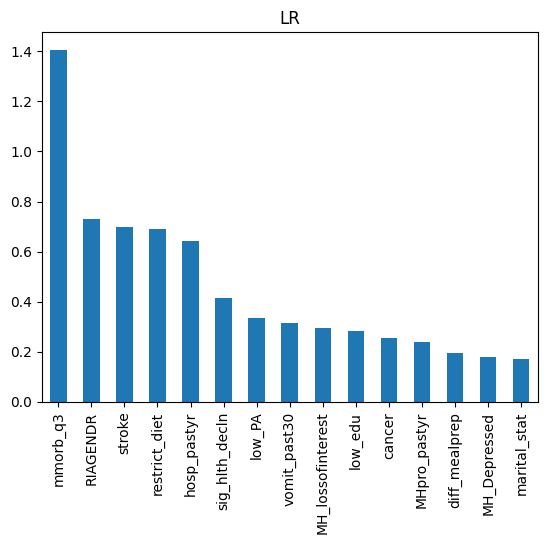

In [72]:
imps['LogisticRegression'].sort_values(ascending=False)[:15].plot.bar()
plt.title("LR")
plt.show()

In [63]:
list(imps['DecisionTreeClassifier'][:7].index)

['low_PA',
 'hosp_pastyr',
 'sig_hlth_decln',
 'func_diffhigh',
 'low_edu',
 'age_cat',
 'mmorb_q3']

In [82]:
set(list(imps['LinearDiscriminantAnalysis'].sort_values(ascending=False).index[:7])) & \
set(list(imps['LogisticRegression'].sort_values(ascending=False).index[:7])) 

{'RIAGENDR',
 'hosp_pastyr',
 'low_PA',
 'mmorb_q3',
 'restrict_diet',
 'sig_hlth_decln',
 'stroke'}

In [32]:
imps

,LogisticRegression,RandomForestClassifier,DecisionTreeClassifier,LinearDiscriminantAnalysis
low_PA,0.332721,0.058412,0.075480,0.336101
hosp_pastyr,0.641946,0.039330,0.026983,0.637975
sig_hlth_decln,0.413494,0.010065,0.012743,0.403808
func_diffhigh,0.105541,0.018232,0.010393,0.109451
low_edu,0.283759,0.060556,0.166702,0.290484
age_cat,0.152616,0.039176,0.025961,0.153824
mmorb_q3,1.407830,0.024348,0.017041,1.400989
memory_prob,0.052894,0.012072,0.005574,0.056704
mobility_lim,0.162991,0.008660,0.005977,0.174492
imp_vision,0.115436,0.011082,0.008879,0.116180


In [111]:
predictors = list(imps['RandomForestClassifier'].sort_values(ascending=False).index)[:25]

### Hyperparameters tuning GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [20]:
grid_params = {'log_reg': {"C":np.logspace(-3,3,7), "penalty":["l2"]},
               'svm': {'C': [0.1, 1, 10, 100, 1000],  
                       'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                       'kernel': ['rbf']},
               'rf': {'n_estimators': [200, 500], 'max_features': ['sqrt', 'log2'], 
                      'max_depth' : [4,5,6,7,8], 'criterion' :['gini', 'entropy']},
               'gnb': {'var_smoothing': np.logspace(0,-9, num=100)},
               'dt': {'max_features': ['sqrt', 'log2'], 'ccp_alpha': [0.1, .01, .001], 
                      'max_depth' : [5, 6, 7, 8, 9], 'criterion' :['gini', 'entropy']},
               'lda': {'solver': ['svd', 'lsqr', 'eigen']},
               'knn': {'n_neighbors': list(range(1, 31))}}

In [21]:
grid_params_vals = list(grid_params.values())

In [119]:
def estimate_acc_gridcv(classifiers, X, y, grid_params_vals):
    
    X_loc, y_loc = X, y
    
    X_train, X_test, y_train, y_test = train_test_split(X_loc, y_loc, test_size=.15)


    skf_grid_search = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    
    results = pd.DataFrame(columns=['clf', 'mean_acc', 'mean_std', 'val_acc', 'val_class0', 'val_class1'])
    
    for i, clf in enumerate(classifiers):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning) # ignore warns from Logreg
            best_clf = GridSearchCV(estimator=clf, param_grid=grid_params_vals[i], 
                                    cv=skf_grid_search, verbose=True, n_jobs=-1)
            
            best_clf.fit(X_train, y_train)
            mean_test_acc, mean_test_std = (pd.DataFrame(best_clf.cv_results_)[pd.DataFrame(best_clf.cv_results_)['rank_test_score'] == 1][['mean_test_score', 'std_test_score']].iloc[0, 0], 
                                 pd.DataFrame(best_clf.cv_results_)[pd.DataFrame(best_clf.cv_results_)['rank_test_score'] == 1][['mean_test_score', 'std_test_score']].iloc[0, 1])
            
            y_pred = best_clf.predict(X_test)
            
            val_acc = accuracy_score(y_pred, y_test)
            
            class_0_val_score, class_1_val_score = (accuracy_score(y_test[y_test == 0.0], y_pred[y_test == 0.0]),
                                                   accuracy_score(y_test[y_test == 1.0], y_pred[y_test == 1.0]))
            
                
            results.loc[i] = (clf, mean_test_acc, mean_test_std, val_acc, class_0_val_score, class_1_val_score)
    
    return results

In [120]:
classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

res = estimate_acc_gridcv(classifiers, X_ov, y_ov, grid_params_vals)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [121]:
res

,clf,mean_acc,mean_std,val_acc,val_class0,val_class1
0,LogisticRegression(max_iter=2000),0.649637,0.022186,0.636933,0.602446,0.673077
1,SVC(),0.882288,0.017608,0.896714,0.831804,0.964744
2,RandomForestClassifier(),0.842217,0.018219,0.856025,0.975535,0.730769
3,GaussianNB(),0.641611,0.026100,0.654147,0.513761,0.801282
4,DecisionTreeClassifier(),0.752140,0.025058,0.741784,0.862385,0.615385
5,LinearDiscriminantAnalysis(),0.645768,0.022122,0.633803,0.593272,0.676282
6,KNeighborsClassifier(),0.814589,0.020769,0.827856,0.724771,0.935897


In [24]:
res

,clf,mean_acc,mean_std,val_acc,val_class0,val_class1
0,LogisticRegression(max_iter=2000),0.641892,0.018421,0.635368,0.636656,0.634146
1,SVC(),0.891681,0.009884,0.879499,0.803859,0.951220
2,RandomForestClassifier(),0.849409,0.017235,0.793427,0.948553,0.646341
3,GaussianNB(),0.633329,0.010538,0.632238,0.504823,0.753049
4,DecisionTreeClassifier(),0.749927,0.024349,0.719875,0.794212,0.649390
5,LinearDiscriminantAnalysis(),0.639957,0.018721,0.632238,0.627010,0.637195
6,KNeighborsClassifier(),0.822611,0.018864,0.826291,0.729904,0.917683


In [25]:
classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

res = estimate_acc_gridcv(classifiers, X_und, y_und, grid_params_vals)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [26]:
res

,clf,mean_acc,mean_std,val_acc,val_class0,val_class1
0,LogisticRegression(max_iter=2000),0.604213,0.024330,0.614583,0.586538,0.647727
1,SVC(),0.600459,0.033859,0.598958,0.653846,0.534091
2,RandomForestClassifier(),0.606065,0.039943,0.625000,0.634615,0.613636
3,GaussianNB(),0.584038,0.040551,0.598958,0.817308,0.340909
4,DecisionTreeClassifier(),0.565486,0.043746,0.609375,0.634615,0.579545
5,LinearDiscriminantAnalysis(),0.602294,0.033561,0.614583,0.605769,0.625000
6,KNeighborsClassifier(),0.567270,0.047668,0.635417,0.682692,0.579545


### test_size=15%

In [27]:
classifiers = (LogisticRegression(max_iter=2000),
               svm.SVC(),
               RandomForestClassifier(),
               GaussianNB(),
               DecisionTreeClassifier(),
               LinearDiscriminantAnalysis(),
               KNeighborsClassifier())

res = estimate_acc_gridcv(classifiers, X_ov, y_ov, grid_params_vals)

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Fitting 10 folds for each of 40 candidates, totalling 400 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 60 candidates, totalling 600 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [28]:
res

,clf,mean_acc,mean_std,val_acc,val_class0,val_class1
0,LogisticRegression(max_iter=2000),0.645483,0.027862,0.658842,0.609677,0.705167
1,SVC(),0.886430,0.009801,0.906103,0.848387,0.960486
2,RandomForestClassifier(),0.841118,0.007703,0.851330,0.964516,0.744681
3,GaussianNB(),0.638577,0.019554,0.643192,0.470968,0.805471
4,DecisionTreeClassifier(),0.734181,0.015652,0.716745,0.758065,0.677812
5,LinearDiscriminantAnalysis(),0.642721,0.027733,0.660407,0.603226,0.714286
6,KNeighborsClassifier(),0.820673,0.017405,0.854460,0.770968,0.933131
